Importar librerías

In [1]:
# Instalar keras-tuner
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn import metrics
import keras_tuner as kt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot
import cv2
from google.colab import drive

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight


from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping


Cargar datos

Mounted at /content/drive


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
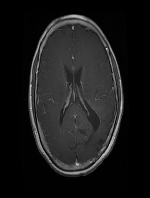

In [3]:
# Cargar bases de datos procesadas
drive.mount('/content/drive')
x_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_test.pkl')

x_train[0]

In [4]:
# Conversión a float32 para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [5]:
# Escalado entre 0 y 1
x_train /= 255
x_test /= 255

In [6]:
# Visualizar forma de las imagenes para luego convertir a 1D
print("Shape x_train:", x_train.shape)
print("Shape x_test:", x_test.shape)

Shape x_train: (5712, 198, 150, 3)
Shape x_test: (1311, 198, 150, 3)


In [7]:
np.prod(x_train[1].shape) # cantidad de variables por imagen

np.int64(89100)

In [8]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3]), array([300, 306, 300, 405]))

Red Neuronal Convolucional NNC

In [ ]:
# Cantidad de clases
num_classes = len(np.unique(y_train))
print(f"Número de clases detectadas: {num_classes}")

cnn_model = Sequential()

# Primera capa convolucional y de pooling
# input_shape es solo para la primera capa
# Conv2D: 32 filtros, tamaño del filtro 3x3, activación ReLU
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]))
# MaxPooling2D: Ventana de pooling 2x2. Reduce la resolución a la mitad.
cnn_model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional y de pooling
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Aplanar la salida de las capas convolucionales antes de las capas densas
cnn_model.add(Flatten())

# Capas densas (como en tu modelo anterior)
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))

# Capa de salida para clasificación multiclase (con softmax y num_classes)
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']) # Añadir más métricas si deseamos, como AUC, Recall, Precision

# Mostrar un resumen de la arquitectura del modelo
cnn_model.summary()

# Guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_cnn_modelo.keras", monitor="val_accuracy", save_best_only=True, mode='max', verbose=1)

# Entrenamiento
history = cnn_model.fit(x_train, y_train,
                        batch_size=100,
                        epochs=5,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])

Número de clases detectadas: 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 110592)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,155,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,183,812 (54.11 MB)

 Trainable params: 14,183,812 (54.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4731 - loss: 1.2846
Epoch 1: val_accuracy improved from -inf to 0.79558, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - accuracy: 0.4759 - loss: 1.2777 - val_accuracy: 0.7956 - val_loss: 0.5618
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8418 - loss: 0.4154
Epoch 2: val_accuracy improved from 0.79558 to 0.86041, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.8421 - loss: 0.4144 - val_accuracy: 0.8604 - val_loss: 0.3672
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9126 - loss: 0.2360
Epoch 3: val_accuracy did not improve from 0.86041
58/58 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.9128 - loss: 0.2356 - val_accuracy: 0.7994 - val_loss: 0.4839
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9386 - loss: 0.1694
Epoch 4: val_accuracy improved from 0.86041 to 0.93974, saving model to mejor_cnn_mode

Optimización de hiperparámetros

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [11]:
# Número de clases
num_classes = len(np.unique(y_train))
print(f"Número de clases detectadas: {num_classes}")

# Modelo optimizado
def build_model(hp):
    filters = hp.Int('filters', min_value=16, max_value=64, step=16)
    dense_units = hp.Int('dense_units', min_value=64, max_value=128, step=64)
    dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)
    reg_l2 = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])

    model = models.Sequential()
    model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(reg_l2),
                            input_shape=x_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate) if optimizer_choice == 'adam' \
               else tf.keras.optimizers.RMSprop(learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Tuner reducido
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory='cnn_tuning',
    project_name='cnn_multiclass_fast'
)

# Búsqueda de hiperparámetros
tuner.search(x_train, y_train,
             validation_data=(x_test, y_test),
             epochs=3,
             batch_size=128,
             callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
             verbose=1)

Trial 5 Complete [00h 16m 11s]
val_accuracy: 0.8375285863876343

Best val_accuracy So Far: 0.9267734289169312
Total elapsed time: 00h 57m 32s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9015 - loss: 0.2798

 Test Accuracy: 0.9268
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step


NameError: name 'confusion_matrix' is not defined

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.9015 - loss: 0.2798

 Test Accuracy: 0.9268
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step

 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       300
           1       0.86      0.88      0.87       306
           2       0.95      0.97      0.96       300
           3       0.99      0.98      0.98       405

    accuracy                           0.93      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311


 Resumen de resultados del tuner:
Results summary
Results in cnn_tuning/cnn_multiclass_fast
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
filters: 16
dense_units: 64
dropout: 0.1
l2_reg: 0.0038519414489155035
lr: 0.009102387826446259
optimizer: adam
Score: 0.9267734289169312

Trial 3 summary
Hyperparameters:
filters: 32
dense_units: 128
d

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 118800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,603,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,603,972 (29.01 MB)

 Trainable params: 7,603,972 (29.01 MB)

 Non-trainable params: 0 (0.00 B)

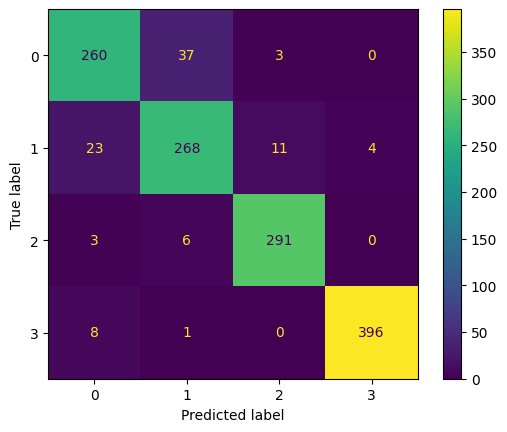

In [13]:
# Evaluación
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"\n Test Accuracy: {test_acc:.4f}")

y_pred = np.argmax(best_model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print("\n Resumen de resultados del tuner:")
tuner.results_summary()

print("\n Estructura del mejor modelo encontrado:")
best_model.summary()

In [ ]:
# -----------------------------
# Preprocesamiento básico
# -----------------------------
# Usamos una muestra más pequeña para pruebas rápidas
x_train_sample = x_train[:3000]
y_train_sample = y_train[:3000]
x_test_sample = x_test[:1000]
y_test_sample = y_test[:1000]

num_classes = len(np.unique(y_train))
print(f"Número de clases detectadas: {num_classes}")

# -----------------------------
# Función para construir modelo
# -----------------------------
def build_model(hp):
    filters_1 = hp.Choice('filters_1', values=[16, 32])
    filters_2 = hp.Choice('filters_2', values=[32, 64])
    dense_1 = hp.Choice('dense_1', values=[64, 128])
    dense_2 = hp.Choice('dense_2', values=[32, 64])
    dropout_rate = hp.Choice('dropout', values=[0.0, 0.2])
    reg_l2 = hp.Choice('l2_reg', values=[1e-4, 1e-3])
    learning_rate = hp.Choice('lr', values=[1e-3, 1e-2])
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])

    model = models.Sequential([
        layers.Conv2D(filters_1, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(reg_l2),
                      input_shape=x_train.shape[1:]),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters_2, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(reg_l2)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),
        layers.Flatten(),
        layers.Dense(dense_1, activation='relu'),
        layers.Dense(dense_2, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) if optimizer_choice == 'adam' \
        else tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# -----------------------------
# Tuner reducido
# -----------------------------
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=3,   # Muy rápido: solo 3 combinaciones
    executions_per_trial=1,
    overwrite=True,
    directory='cnn_tuning_fast',
    project_name='quick_test'
)

# -----------------------------
# Ejecución rápida de búsqueda
# -----------------------------
tuner.search(x_train_sample, y_train_sample,
             validation_data=(x_test_sample, y_test_sample),
             epochs=3,  # Solo 3 épocas
             batch_size=100,
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
             verbose=2)

# -----------------------------
# Evaluar mejor modelo
# -----------------------------
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(x_test_sample, y_test_sample)
print(f"\n Test Accuracy (versión rápida): {test_acc:.4f}")